In [1]:
import VariationalBayes as vb
import VariationalBayes.ExponentialFamilies as ef

import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, unpack_csr_matrix, get_sparse_hessian

import matplotlib.pyplot as plt
%matplotlib inline

#import numpy as np

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

#analysis_name = 'simulated_data_small'
analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')


pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)

pkl_file = open(pickle_output_filename, 'rb')
vb_results = pickle.load(pkl_file)


In [3]:
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
y_g_vec, y_vec, x_mat, glmm_par, prior_par = logit_glmm.load_json_data(json_filename)

# Load the glmer results
glmer_json_filename = os.path.join(data_dir, '%s_glmer_results.json' % analysis_name)
json_file = open(glmer_json_filename, 'r')
glmer_dat = json.load(json_file)
json_file.close()

K = x_mat.shape[1]
NG = np.max(y_g_vec) + 1

# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)


dict_keys(['tau_prior_alpha', 'K', 'y', 'mu_prior_info', 'beta_prior_info', 'mu_prior_mean', 'tau_prior_beta', 'NG', 'beta_prior_mean', 'y_group', 'N', 'x'])


In [4]:
mle_par = logit_glmm.get_mle_parameters(K=K, NG=NG)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)
glmm_par.set_free(vb_results['glmm_par_free'])

set_from_glmer = False
if set_from_glmer:
    mle_par['beta'].set(np.array(glmer_dat['beta_mean']))
    mle_par['mu'].set(np.array(glmer_dat['mu_mean']))
    mle_par['tau'].set(np.array(glmer_dat['tau_mean']))
    mle_par['u'].set(np.array(glmer_dat['u_map']))
else:
    # Set from VB
    mle_par['beta'].set(glmm_par['beta'].e())
    mle_par['mu'].set(glmm_par['mu'].e())
    mle_par['tau'].set(glmm_par['tau'].e())
    mle_par['u'].set(glmm_par['u'].e())

model = logit_glmm.LogisticGLMMMaximumLikelihood(mle_par, prior_par, x_mat, y_vec, y_g_vec)
print(model.get_log_lik())

objective = Objective(fun=model.get_log_loss, par=model.mle_par)
print(objective.fun_free(model.mle_par.get_free()))

-26517.704163969633
26517.704164


In [5]:

#u_free_init = model.mle_par['u'].get_free()
u_free_init = np.random.random(model.mle_par.free_size())
objective.logger.initialize()
objective.logger.print_every = 20
map_time = time.time()
mle_opt = optimize.minimize(
    lambda par: objective.fun_free(par, verbose=True),
    x0=u_free_init,
    method='trust-ncg',
    jac=objective.fun_free_grad,
    hessp=objective.fun_free_hvp,
    tol=1e-6, options={'maxiter': 200, 'disp': True, 'gtol': 1e-6 })
map_time = time.time() - map_time
free_opt = mle_opt.x

print(map_time)

Iter  0  value:  68816.5662039
	x_diff:  inf
Iter  20  value:  21571.1955099
	x_diff:  2.86335565037
Iter  40  value:  16142.0040967
	x_diff:  0.00100598273949
         Current function value: 16029.288280
         Iterations: 51
         Function evaluations: 53
         Gradient evaluations: 52
         Hessian evaluations: 0
12.167274951934814


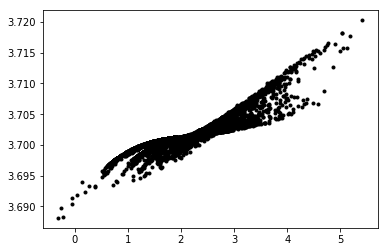

In [6]:
model.mle_par.set_free(free_opt)
tau_mle = model.mle_par['u'].get()
u_mle = model.mle_par['u'].get()

glmm_par.set_free(vb_results['glmm_par_free'])
u_vb = glmm_par['u'].e()

plt.plot(u_vb, u_mle, 'k.')

In [16]:
model.mle_par.set_free(free_opt)
mle_moment_par = logit_glmm.set_moment_par_from_mle(moment_wrapper.moment_par, model.mle_par)
print(mle_moment_par)
mle_moment_par_vector = copy.deepcopy(mle_moment_par.get_vector())

print('---------\n')
moment_wrapper.set_moments(vb_results['glmm_par_free'])
print(moment_wrapper.moment_par)

Moment Parameters:
	e_beta:
[ 1.89907663  0.1977702   0.10286525 -0.17270265  0.28043579]
	e_mu: [ 3.70136964]
	e_tau: [ 827.72417176]
	e_log_tau: [ 6.71867997]
	e_u:
[ 3.70600463  3.70378225  3.70996836 ...,  3.70117042  3.69932516
  3.69682295]
---------

Moment Parameters:
	e_beta:
[ 1.44700085  0.03296895  0.11030994 -0.17308099  0.27302143]
	e_mu: [ 2.04149248]
	e_tau: [ 0.82340528]
	e_log_tau: [-0.19450654]
	e_u:
[ 3.21159129  3.3788278   3.78659004 ...,  1.84961682  1.57920182
  0.64982441]


/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/VariationalBayes/Parameters.py:182: RuntimeWarning: invalid value encountered in less
  if (np.array(val < self.__lb)).any():
/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/VariationalBayes/Parameters.py:184: RuntimeWarning: invalid value encountered in greater
  if (np.array(val > self.__ub)).any():


In [17]:
# Write the result to a JSON file for use in R.

run_name = 'production'

pickle_output_filename = os.path.join(data_dir, '%s_python_vb_map_results.pkl' % analysis_name)
pickle_output = open(pickle_output_filename, 'wb')

# Unlike with JSON, numpy arrays can be pickled.
model.mle_par.set_free(free_opt)
pickle_result_dict = {  'run_name': run_name,
                        'pickle_output_filename': pickle_output_filename,
                        'map_time': map_time,
                        'mle_moment_par_vector': mle_moment_par_vector,
                        'mle_par_dictval': model.mle_par.dictval(),
                        'mle_par_vector': model.mle_par.get_vector(),
                        'mle_par_free': model.mle_par.get_free()
                     }

# Pickle dictionary using protocol 0.
pickle.dump(pickle_result_dict, pickle_output)
pickle_output.close()

print(pickle_output_filename)


print('\n\nDONE.')


/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/criteo_subsampled_python_vb_map_results.pkl


DONE.
